<div style="background-color: orange; padding: 20px; text-align: center; font-size: 22px;">
    <strong>Analyse descriptive</strong><br>
    <em>(pour la recommandation)</eiv>>

<h1 align="center"><strong style="color: orange;">1. Importing modules</strong></h1>

In [26]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from pprint import pprint
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import DistanceMetric

<h1 align="center"><strong style="color: orange;">2. Data import</strong></h1>

We import the data into dataframes and make sure to indicate that the files have headers

In [100]:
movies = pd.read_excel('movies.xlsx', header=0)
ratings = pd.read_excel('ratings.xlsx', header=0)
users = pd.read_excel('users.xlsx', header=0)

We then analyze the dimensions of each of my dataframes

In [230]:
dataframes = {'movies': movies, 'ratings': ratings, 'users': users}

for df_name, df in dataframes.items():
    num_rows, num_columns = df.shape
    columns_list = list(df.columns)
    print(f"{df_name} (row's number, col's number) : ({num_rows}, {num_columns})")
    print(f"Colonnes : {columns_list}\n")

movies (row's number, col's number) : (3883, 4)
Colonnes : ['MovieID', 'Title', 'Genres', 'Year']

ratings (row's number, col's number) : (1000209, 4)
Colonnes : ['UserID', 'MovieID', 'Rating', 'Timestamp']

users (row's number, col's number) : (6040, 5)
Colonnes : ['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code']



<h3 align="left"><strong style="color: brown;">2.1 Movies</strong></h3>

Some MovieIDs do not correspond to a movie due to accidental duplicate entries and/or test entries.

In [50]:
movies[1:5]

,MovieID,Title,Genres,Year
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1954
2,3,Grumpier Old Men (1995),Comedy|Romance,1995
3,4,Waiting to Exhale (1995),Comedy|Drama,1919
4,5,Father of the Bride Part II (1995),Comedy,1919


In [48]:
all_genres = (
    movies["Genres"]
    .str.split('|')         
    .explode()          
    .dropna()          
    .unique()         
)

all_genres = sorted(all_genres)

The titles are identical to the titles provided by IMDB (including the release year).
The genres are separated by vertical bars "|" and are chosen from the following genres : \n

| | | |
| :--- | :--- | :--- |
| Action | Adventure | Animation |
| Children's | Comedy | Crime |
| Documentary | Drama | Fantasy |
| Film-Noir | Horror | Musical |
| Mystery | Romance | Sci-Fi |
| Thriller | War | Western |estern

<h3 align="left"><strong style="color: brown;">2.2 Ratings</strong></h3>

In [55]:
ratings[1:5]

,UserID,MovieID,Rating,Timestamp
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


- UserID (User ID): User IDs range from 1 to 6040.
- MovieID (Movie ID): Movie IDs range from 1 to 3952.
- Rating: Ratings are on a 5-star scale (only integer values).
- Timestamp: The timestamp is represented in seconds since the Unix epoch (as returned by time(2)).
- Each user has at least 20 ratings.

<h3 align="left"><strong style="color: brown;">2.3 Users</strong></h3>

In [62]:
users[1:5]

,UserID,Gender,Age,Occupation,Zip-code
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,2460
4,5,M,25,20,55455


All demographic information is provided voluntarily by users and is not verified for accuracy. Only users who have provided demographic information are included in this dataset.

Gender is indicated by "M" for male and "F" for female.

Age is selected from the following ranges:

| Code | Age Range |
| :--- | :--- |
| 1 | Under 18 |
| 18 | 18-24 |
| 25 | 25-34 |
| 35 | 35-44 |
| 45 | 45-49 |
| 50 | 50-55 |
| 56 | 56+ | (56+) |

The occupation is chosen from the following :

| Code | Occupation | Code | Occupation |
| :--- | :--- | :--- | :--- |
| 0 | Autre ou non spécifié | 11 | Avocat |
| 1 | Enseignant/Éducateur | 12 | Programmeur |
| 2 | Artiste | 13 | Retraité |
| 3 | Travail de bureau/Administratif | 14 | Vente/Marketing |
| 4 | Étudiant universitaire/Étudiant diplômé | 15 | Scientifique |
| 5 | Service client | 16 | Travailleur indépendant |
| 6 | Médecin/Professionnel de la santé | 17 | Technicien/Ingénieur |
| 7 | Cadre/Manager | 18 | Artisan/Manœuvre |
| 8 | Agriculteur | 19 | Sans emploi |
| 9 | Homme/Femme au foyer | 20 | Écrivain |
| 10 | Étudiant de la maternelle au secondaire | | |

<h1 align="center"><strong style="color: orange;">3. Dataframes analysis</strong></h1>

<h2 align="center"><strong style="color: green;">3.1 Movies</strong></h2>

<h3 align="left"><strong style="color: brown;">1 Corrections</strong></h3>

As previously mentioned, the data contained in the **movies** dataframe is not properly formatted for full use:

- The release years of the films are joined to the titles; they will need to be separated.
- Some determiners are placed before the film name, such as (American President, The); these will need to be moved to the front.
- The genres are concatenated; they will need to be converted into a list to be used effectively.

In [102]:
def extract_year(title):
    if isinstance(title, str):
        matches = re.findall(r'\((\d{4})\)', title)
        if matches:
            return int(matches[-1])
    return None
movies['Year'] = movies['Title'].apply(extract_year)
def rearrange_title(title):
    if not isinstance(title, str):
        # If the input is not a string, return it as is
        return title
    
    pattern = r'^(.*?)(,\s*(The|A))?\s*\((\d{4})\)$'
    match = re.match(pattern, title, re.IGNORECASE)
    
    if match:
        determinant = match.group(3) or ""  # Handle the case where there is no "The" or "A"
        year = match.group(4)
        return f'{determinant} {match.group(1)} ({year})'
    return title

movies['Title'] = movies['Title'].apply(rearrange_title)
ratings['MovieID'] = ratings['MovieID'].astype(int)
movies['MovieID'] = movies['MovieID'].astype(int)
movies['Genres'] = movies['Genres'].apply(lambda x: re.split(r'[;|]', x))
movies['Title'] = movies['Title'].str.strip()

In [87]:
movies[1:5]

,MovieID,Title,Genres,Year
1,2,Jumanji (1995),"[Adventure, Children's, Fantasy]",1995.0
2,3,Grumpier Old Men (1995),"[Comedy, Romance]",1995.0
3,4,Waiting to Exhale (1995),"[Comedy, Drama]",1995.0
4,5,Father of the Bride Part II (1995),[Comedy],1995.0


In [89]:
missing_values_per_column = movies.isnull().sum()
print(missing_values_per_column)

MovieID    0
Title      0
Genres     0
Year       0
dtype: int64


<h3 align="left"><strong style="color: brown;">2 Analysis</strong></h3>

We are going to perform analyses on each column of my dataframe, and I'll start by analyzing the distribution of years.

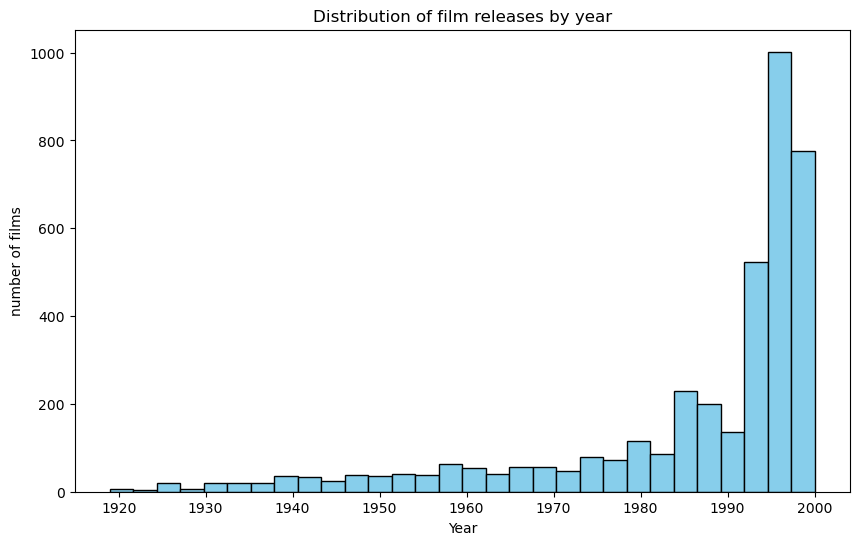

In [106]:
plt.figure(figsize=(10, 6))
plt.hist(movies['Year'].dropna(), bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Year')
plt.ylabel('number of films')
plt.title('Distribution of film releases by year')
plt.show()

The graph shows a significant increase in the number of film releases over the course of the century.

Next, we analyze the frequency of the different genres in our dataframe. To do this, we first create a table with the genres and the number of times they appear. Then, we create a pie chart for a more visual representation.

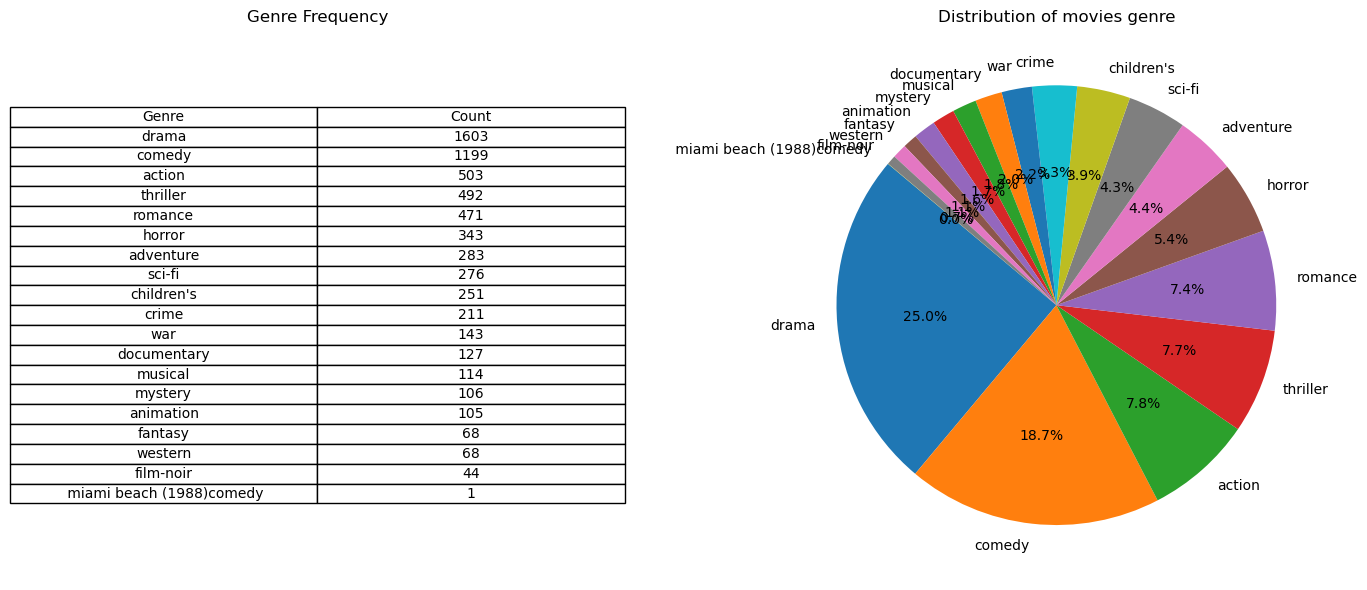

In [125]:
genres_series = movies.explode('Genres')['Genres']
genres_series = genres_series.str.lower()

genre_counts = genres_series.value_counts()
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.axis('off')
plt.table(cellText=genre_counts.reset_index().values,
          colLabels=['Genre', 'Count'],
          cellLoc='center', 
          loc='center')
plt.title('Genre Frequency')
plt.subplot(1, 2, 2)
plt.pie(genre_counts, labels=genre_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of movies genre')
plt.tight_layout()
plt.show()

Thus, we see that the 3 most present genres in our dataframe are : drama, comedy and action.

We also want to see the distribution of genres according to the years in our dataframe, so we make a bar chart for this.

<Figure size 1200x600 with 0 Axes>

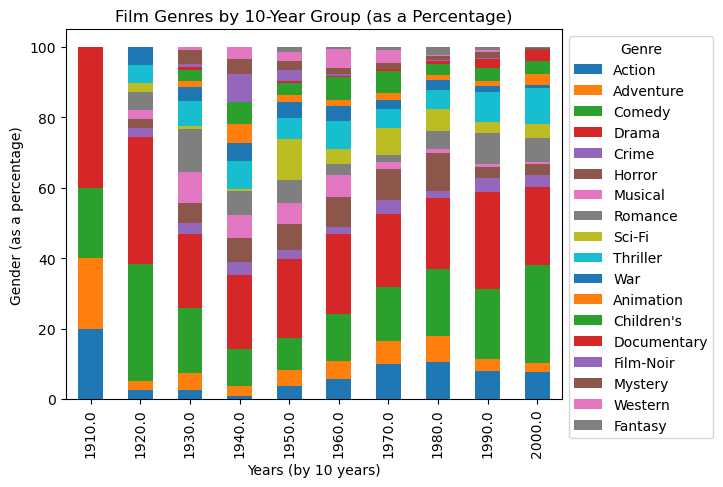

In [114]:
movies_expanded = movies.explode('Genres')
movies_expanded['YearGroup'] = (movies_expanded['Year'] // 10) * 10
genre_counts_by_year = movies_expanded.groupby(['YearGroup', 'Genres']).size().unstack()
genre_percentages_by_year = genre_counts_by_year.div(genre_counts_by_year.sum(axis=1), axis=0) * 100
plt.figure(figsize=(12, 6))
genre_percentages_by_year.plot(kind='bar', stacked=True)
plt.xlabel('Years (by 10 years)')
plt.ylabel('Gender (as a percentage)')
plt.title('Film Genres by 10-Year Group (as a Percentage)')
plt.legend(title='Genre', bbox_to_anchor=(1, 1))
plt.show()

We observe that drama is the most produced genre in each decade, followed by comedy. However, we can see that action is the genre making a comeback, while animation is disappearing.

<h2 align="center"><strong style="color: green;">3.2 Ratings</strong></h2>

<h3 align="left"><strong style="color: brown;">1 Correction </strong></h3>

In [127]:
missing_values_per_column = ratings.isnull().sum()
print(missing_values_per_column)

UserID       0
MovieID      0
Rating       0
Timestamp    0
dtype: int64


In [129]:
ratings[1:5]

,UserID,MovieID,Rating,Timestamp
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


We want to check that a user hasn't rated a film multiple times because that could skew our model.

In [133]:
duplicates = ratings.duplicated(subset=['UserID', 'MovieID'])
ratings[duplicates]

,UserID,MovieID,Rating,Timestamp


There are no users who have rated the same film multiple times.

There is no missing data and the data also appears to be correct, so we can proceed with the analysis.

<h3 align="left"><strong style="color: brown;">2 Analysis </strong></h3>

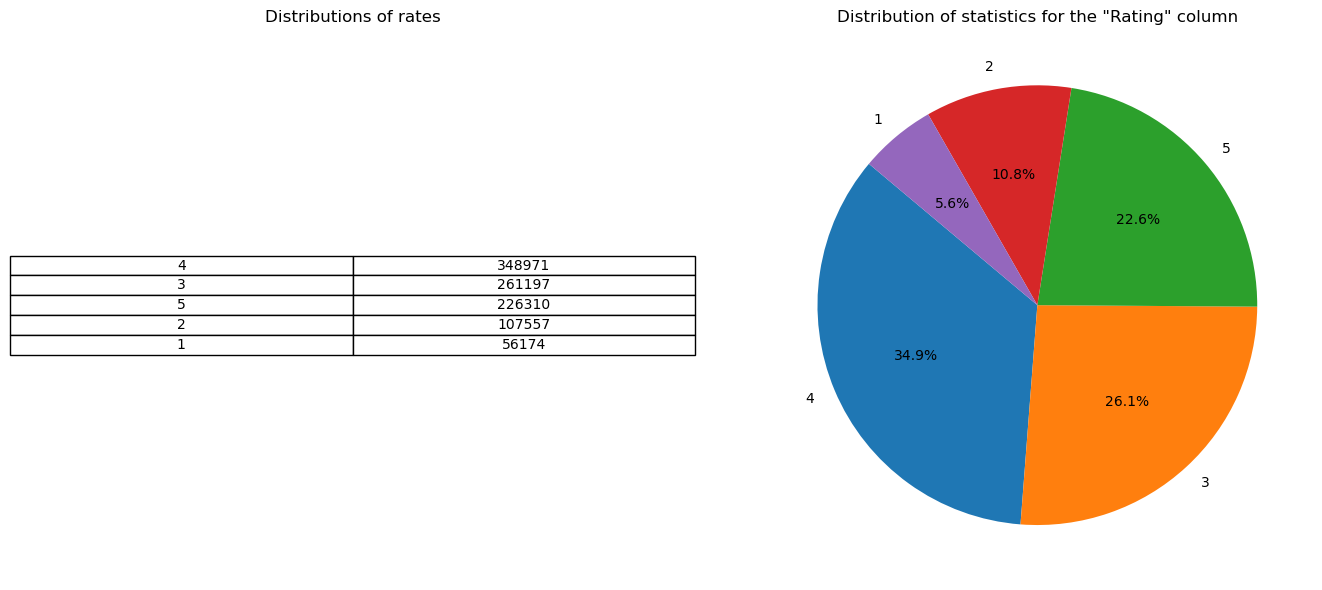

In [142]:
rating_stats = ratings['Rating'].value_counts()
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.axis('off')
plt.table(cellText=rating_stats.reset_index().values,
          cellLoc='center', 
          loc='center')
plt.title('occurence of notes')
plt.subplot(1, 2, 2)
plt.pie(rating_stats, labels=rating_stats.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of statistics for the "Rating" column')
plt.tight_layout()
plt.show()

We can see here that there are mostly positive ratings. <br>
There could be several explanations: either the people who rated the films are kind, or the films offered are truly excellent, or when a film is bad, people don't vote.

Next, I wanted to know what overall rating each genre had received; for this, it was not enough to only take the ratings given to each genre, but also to take into account the number of times they were viewed in order to be more objective.

In [150]:
merged_data = ratings.merge(movies, on='MovieID')
genre_stats = merged_data.explode('Genres').groupby('Genres').agg({'Rating': ['count', 'mean']})
max_count = genre_stats[('Rating', 'count')].max()
max_rating = genre_stats[('Rating', 'mean')].max()
normalized_counts = 5 * (genre_stats[('Rating', 'count')]/max_count)
normalized_ratings = 5 * (genre_stats[('Rating', 'mean')]/max_rating)
genre_stats[('Rating', 'normalized_score')] = 0.5 * (normalized_counts + normalized_ratings)
genre_stats.columns = ['Number of occurrences', 'Average rating', 'Standardized rating']
genre_stats = genre_stats.sort_values('Standardized rating', ascending=False)
print(genre_stats)

                           Number of occurrences  Average rating  \
Genres                                                             
Drama                                     354529        3.766332   
Comedy                                    356430        3.522838   
Action                                    257457        3.491185   
Thriller                                  189680        3.570466   
Romance                                   147523        3.607465   
Sci-Fi                                    157294        3.466521   
Adventure                                 133953        3.477257   
War                                        68527        3.893327   
Crime                                      79541        3.708679   
Film-Noir                                  18261        4.075188   
Children's                                 72186        3.422035   
Animation                                  43293        3.684868   
Musical                                    41533

Then we do the same to find the 5 highest rated films and the 5 lowest rated films.

In [160]:
merged_data = ratings.merge(movies, on='MovieID')
movie_stats = merged_data.groupby('Title').agg({'Rating': ['mean', 'count']})
movie_stats.columns = ['Average rating', 'viewings']
total_visionnages = movie_stats['viewings'].sum()
movie_stats['Weighted average score'] = (movie_stats['Average rating'] * movie_stats['viewings']) / total_visionnages
min_rating = movie_stats['Weighted average score'].min()
max_rating = movie_stats['Weighted average score'].max()
movie_stats['Average rating on 5'] = ((movie_stats['Weighted average score'] - min_rating) / (max_rating - min_rating)) * 5
sorted_movies = movie_stats.sort_values(by='Average rating on 5', ascending=False)
top_5_movies = sorted_movies.head(5)[['Average rating','Average rating on 5', 'viewings']]
print("=======================================================")
print("Top 5 highest-rated films with total number of views :")
print("=======================================================")
print(top_5_movies)
worst_5_movies = sorted_movies.tail(5)[['Average rating','Average rating on 5', 'viewings']]
print("\n=======================================================")
print("Top 5 lowest-rated films with total number of views:")
print("=======================================================")
print(worst_5_movies)

Top 5 highest-rated films with total number of views :
                                                    Average rating  \
Title                                                                
American Beauty (1999)                                    4.317386   
Star Wars Episode IV - A New Hope (1977)                  4.453694   
Star Wars Episode V - The Empire Strikes Back (...        4.292977   
Star Wars Episode VI - Return of the Jedi (1983)          4.022893   
Saving Private Ryan (1998)                                4.337354   

                                                    Average rating on 5  \
Title                                                                     
American Beauty (1999)                                         5.000000   
Star Wars Episode IV - A New Hope (1977)                       4.500304   
Star Wars Episode V - The Empire Strikes Back (...             4.336442   
Star Wars Episode VI - Return of the Jedi (1983)               3.918170   
Savi

We then checked that the most viewed films were not automatically placed in the best films because we also had to take into account the ratings of what works well because in our previous ranking *saving private Ryan* was in 5th position (it took into account the ratings and the number of views) whereas the ranking we just made shows us that it is only in 7th position (we only take into account the number of views).

In [163]:
total_ratings = merged_data.groupby('Title')['Rating'].count()
top_5_most_watched = total_ratings.nlargest(10)
print("Top 10 des films les plus visionnés :")
print(top_5_most_watched)

Top 10 des films les plus visionnés :
Title
American Beauty (1999)                                  3428
Star Wars Episode IV - A New Hope (1977)                2991
Star Wars Episode V - The Empire Strikes Back (1980)    2990
Star Wars Episode VI - Return of the Jedi (1983)        2883
Jurassic Park (1993)                                    2672
Saving Private Ryan (1998)                              2653
Terminator 2 Judgment Day (1991)                        2649
The Matrix (1999)                                       2590
Back to the Future (1985)                               2583
The Silence of the Lambs (1991)                         2578
Name: Rating, dtype: int64


<h2 align="center"><strong style="color: green;">3.3 Users</strong></h2>

<h3 align="left"><strong style="color: brown;">1 Corrections </strong></h3>

In [173]:
ratings[1:5]

,UserID,MovieID,Rating,Timestamp
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [175]:
valeurs_manquantes_par_colonne = users.isnull().sum()
print(valeurs_manquantes_par_colonne)

UserID        0
Gender        0
Age           0
Occupation    0
Zip-code      0
dtype: int64


There is no missing data and the data also appears to be correct, so we can proceed with the analysis.

<h3 align="left"><strong style="color: brown;">2 Analysis </strong></h3>

We first try to see the overall distribution of the different characteristics of the users, and then to see which demographic groups are the most represented, and the least represented.

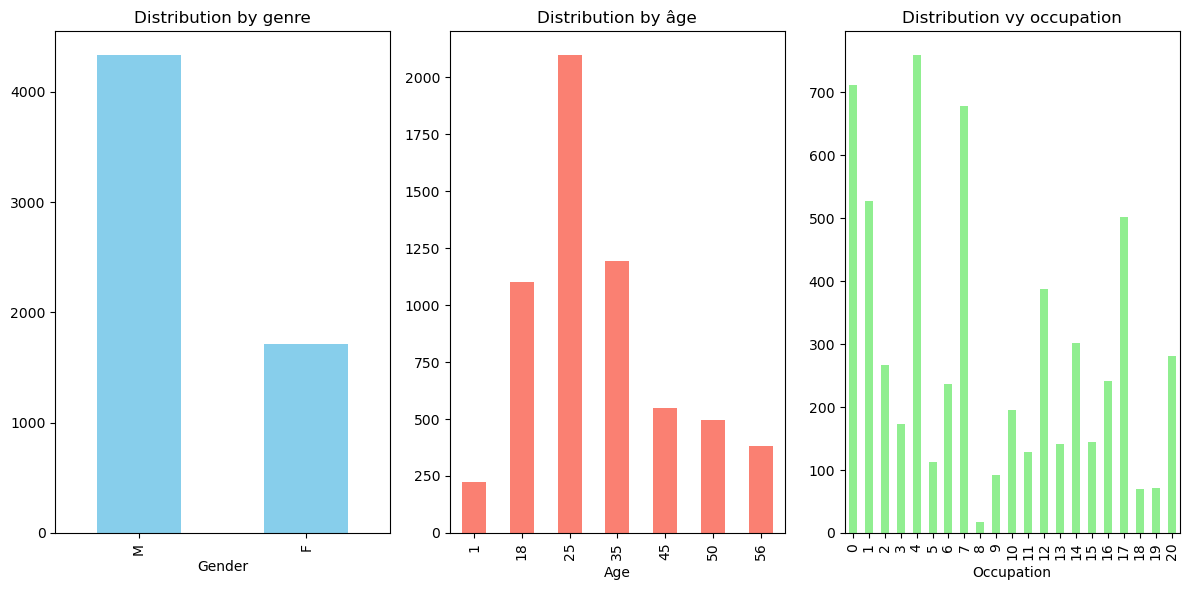


Top 5 most represented demographic groups:
    Gender  Age  Occupation  Count
127      M   18           4    371
143      M   25           0    206
150      M   25           7    191
159      M   25          17    180
170      M   35           7    177

Top 5 least represented demographic groups :
    Gender  Age  Occupation  Count
50       F   35           8      1
211      M   50           8      1
109      F   56          20      1
173      M   35          10      1
153      M   25          10      1


In [191]:
genre_distribution = users['Gender'].value_counts()
age_distribution = users['Age'].value_counts().sort_index()
occupation_distribution = users['Occupation'].value_counts().sort_index()
most_frequent_gender = genre_distribution.idxmax()
most_frequent_age = age_distribution.idxmax()
most_frequent_occupation = occupation_distribution.idxmax()
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
genre_distribution.plot(kind='bar', color='skyblue')
plt.title('Distribution by genre')
plt.subplot(1, 3, 2)
age_distribution.plot(kind='bar', color='salmon')
plt.title('Distribution by âge')
plt.subplot(1, 3, 3)
occupation_distribution.plot(kind='bar', color='lightgreen')
plt.title('Distribution vy occupation')
plt.tight_layout()
plt.show()
grouped_data = users.groupby(['Gender', 'Age', 'Occupation']).size().reset_index(name='Count')
sorted_groups = grouped_data.sort_values(by='Count', ascending=False)
top_3_most_present = sorted_groups.head(5)
top_3_least_present = sorted_groups.tail(5)
print("=======================================================")
print("\nTop 5 most represented demographic groups:")
print(top_3_most_present)
print("=======================================================")
print("\nTop 5 least represented demographic groups :")
print(top_3_least_present)

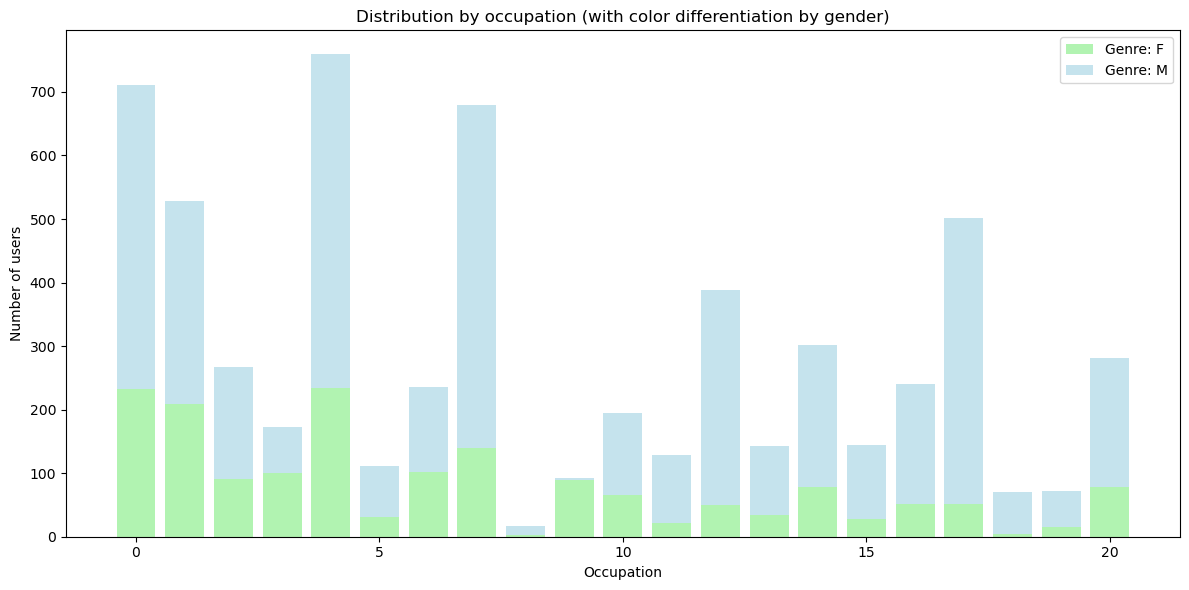

In [193]:
genre_distribution = users['Gender'].value_counts()
occupation_distribution = users.groupby('Gender')['Occupation'].value_counts().unstack().fillna(0)

plt.figure(figsize=(12, 6))

colors = ['lightgreen', 'lightblue']

for i, gender in enumerate(occupation_distribution.index):
    plt.bar(occupation_distribution.columns, occupation_distribution.loc[gender], label=f'Genre: {gender}', color=colors[i], alpha=0.7, bottom=occupation_distribution.iloc[:i].sum())

plt.xlabel('Occupation')
plt.ylabel("Number of users")
plt.title('Distribution by occupation (with color differentiation by gender)')
plt.legend()
plt.tight_layout()
plt.show()

It can be observed that overall, men are more represented than women in almost all categories. However, there are certain occupations represented solely by one sex. For example, in our database, only women are listed as 'homemakers'. Furthermore, the occupations of 732 individuals remain unknown.

<h1 align="center"><strong style="color: orange;">4. Correlation analysis</strong></h1>

In [198]:
merged_data = ratings.merge(users, on='UserID')
correlation_age_rating = merged_data['Age'].corr(merged_data['Rating'])
print('the correlation between age and grades :',correlation_age_rating)
from scipy.stats import f_oneway
result = f_oneway(*[group['Rating'] for name, group in merged_data.groupby('Occupation')])
print('ANOVA test between occupation and evaluations :',result)

the correlation between age and grades : 0.05686866189092932
ANOVA test between occupation and evaluations : F_onewayResult(statistic=134.42149523249284, pvalue=0.0)


The correlation between age and ratings is very weak and positive (0.0568). This means there is a very weak link between individuals' ages and the ratings they give. The ANOVA test revealed a statistically significant difference between at least two occupational groups with respect to ratings. <br>
The high F-statistic (134.42) and the very low p-value (0.0) indicate that this difference is probably not due to chance. These results suggest that there is a statistical relationship between age and ratings, although this relationship is very weak, and that there are significant differences in ratings across different occupations. For a more precise interpretation, further details about the data and the study context would be needed.

In [225]:
merged_data = ratings.merge(users, on='UserID')
merged_data = merged_data.merge(movies, on='MovieID')


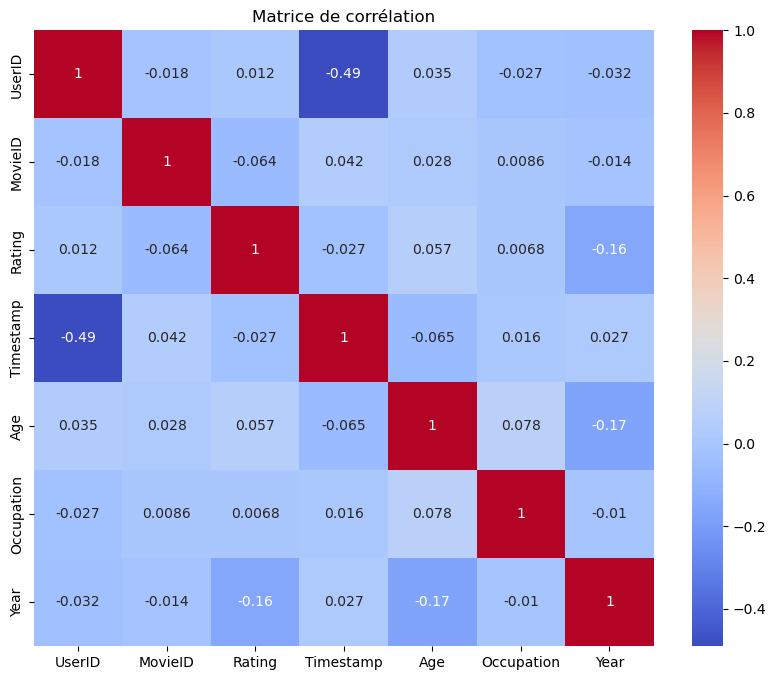

In [227]:
correlation_matrix = merged_data.select_dtypes(include=['number']).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Matrice de corrélation')
plt.show()

It appears that no significant correlations were identified between the variables in the correlation matrix, meaning that no clear axis or strong linear relationship exists between them. In other words, no pair of variables is strongly correlated to the point of justifying the removal of certain columns to simplify the database. Therefore, it is not possible to simplify the database by eliminating unnecessary columns based on the observed correlations.

In [232]:
merged_data.to_csv('merged_data.csv', sep = ";")